# Exploring complexity

Hi guys ! Through this notebook, I'll take you with me in my journey to explore the potential of complexity measures in realtime processing of EEG signals. 


Because the goal of this notebook is only  

In [1]:
from mne.io import read_raw_fif
import mne
from brainpipe.feature import power
import numpy as np
import neurokit
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import ttest_ind

%matplotlib notebook

In [7]:
# 1.
# Fetch time series data from any file whatsoever
# Must be at least 30 seconds at 250Hz

raw_rs = read_raw_fif('/home/hyruuk/GitHub/my_eegsynth/datafiles/SA04_01_preprocessed.fif.gz', preload=True).resample(250)
raw_task = read_raw_fif('/home/hyruuk/GitHub/my_eegsynth/datafiles/SA04_02_preprocessed.fif.gz', preload=True).resample(250)
sfreq = raw_rs.info['sfreq']

Opening raw data file /home/hyruuk/GitHub/my_eegsynth/datafiles/SA04_01_preprocessed.fif.gz...


<ipython-input-7-c5cea1a0582e>:5: RuntimeWarning: This filename (/home/hyruuk/GitHub/my_eegsynth/datafiles/SA04_01_preprocessed.fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_rs = read_raw_fif('/home/hyruuk/GitHub/my_eegsynth/datafiles/SA04_01_preprocessed.fif.gz', preload=True).resample(250)


    Read 5 compensation matrices
    Range : 0 ... 431999 =      0.000 ...   359.999 secs
Ready.
Current compensation grade : 3
Reading 0 ... 431999  =      0.000 ...   359.999 secs...
Opening raw data file /home/hyruuk/GitHub/my_eegsynth/datafiles/SA04_02_preprocessed.fif.gz...


<ipython-input-7-c5cea1a0582e>:6: RuntimeWarning: This filename (/home/hyruuk/GitHub/my_eegsynth/datafiles/SA04_02_preprocessed.fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_task = read_raw_fif('/home/hyruuk/GitHub/my_eegsynth/datafiles/SA04_02_preprocessed.fif.gz', preload=True).resample(250)


    Read 5 compensation matrices
    Range : 0 ... 587999 =      0.000 ...   489.999 secs
Ready.
Current compensation grade : 3
Reading 0 ... 587999  =      0.000 ...   489.999 secs...
Trigger channel has a non-zero initial value of 10 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1603 events found
Event IDs: [21 31 99]
Trigger channel has a non-zero initial value of 10 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1595 events found
Event IDs: [21 31 99]


<ipython-input-7-c5cea1a0582e>:6: RuntimeWarning: Resampling of the stim channels caused event information to become unreliable. Consider finding events on the original data and passing the event matrix as a parameter.
  raw_task = read_raw_fif('/home/hyruuk/GitHub/my_eegsynth/datafiles/SA04_02_preprocessed.fif.gz', preload=True).resample(250)


In [10]:

def slice_into_epochs(raw, n_timepoints=3000):
    # Average all channels and slice into epochs
    picks = mne.pick_types(raw.info, meg=True, eeg=False)
    all_timeseries = np.mean(raw.get_data(picks=picks)[:,:], axis=0)
    
    xs = np.array([x for x in range(0, raw_rs.get_data(picks=picks).shape[1], 3000)])
    eeg_timeseries = []
    for x in xs:
        start = x
        stop = x + 3000
        if stop < len(all_timeseries):
            eeg_timeseries.append(all_timeseries[start:stop])
    timeseries = np.array(eeg_timeseries)
    return timeseries

timeseries_rs = slice_into_epochs(raw_rs, n_timepoints=3000)
timeseries_task = slice_into_epochs(raw_task, n_timepoints=3000)
timeseries_rs.shape

(29, 3000)

In [79]:
# 2.
# Compute hilbert using brainpipe
def get_hilbert(data, freq=1):
    # data = n_elec * n_timepoints
    f = [[4, 8], [8, 12], [12, 30], [30,60]]
    power_obj = power(sfreq, npts=data.shape[1], f=f, baseline=None, norm=None, method='hilbert', window=None, width=None, step=None, split=None, time=None)
    power_vals = power_obj.get(data.T)[0].squeeze() # get power values across time
    power_vals = power_vals[freq,:,:].T
    return power_vals




In [12]:
# 3.
# Compute complexity using neurokit
start = time.time()
comp = neurokit.complexity(eeg_timeseries)
stop = time.time()
print("duration of computation :")
print(stop-start)
print(comp)


NameError: name 'eeg_timeseries' is not defined

In [72]:
### Compare the Hurst and complexity values of pure sine, white, pink and brown noise.

In [2]:
from acoustics.generator import noise

np.random.seed(0) 
fs = 100
dur = 30



# Let's do the same with simulated data ! 

# First we can generate a pure tone at a frequency of 10Hz
samples = np.linspace(0, dur, dur * fs)
n_samples = len(samples)
freq = 0.1
pure = np.sin(2 * np.pi * freq * samples)

white_noise = noise(n_samples, color='white') # A good model for EEG signals can be... Sound signals !
pink_noise = noise(n_samples, color='pink') # Both are complex time series with a wide spectral content.
brown_noise = noise(n_samples, color='brown') # The acoustics toolbox will help us design various flavours of noise !
blue_noise = noise(n_samples, color='blue')
eeg_timeseries = ep_wake[0,:] # We take only the first epoch
eeg_alphaEnv = get_hilbert(ep_wake, freq=1)[0,:]
eeg_thetaEnv = get_hilbert(ep_wake, freq=0)[0,:]


# Let's create a small plotting function to visualize the timeseries
def timeseries_plot(sig, ax, title = None):
    ax.plot(sig)
    ax.set_xlabel('time (sample)', fontsize=12)
    ax.set_ylabel('value', fontsize=12)
    ax.set_title(title, fontsize=20)

# Now we stack the signals in a list so we can plot them easily through a loop
sigs = [blue_noise, white_noise, pink_noise, brown_noise, pure, eeg_timeseries, eeg_alphaEnv, eeg_thetaEnv]
sig_names = ['Blue noise', 'White noise', 'Pink noise', 'Brown noise', 'Pure sine', 'EEG timeseries', 'EEG alpha', 'EEG theta']




fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10), constrained_layout=True)
for i, ax in enumerate(axs.flat):
    timeseries_plot(sigs[i], ax, title=sig_names[i])



    


ModuleNotFoundError: No module named 'acoustics'

### Wow dem curves looks great !

But... How do I know these signals are really what they pretend to be ?

Also, what are blue/white/pink/brown noises ?

They all look blue to me...

/home/hyruuk/anaconda3/envs/cbc/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


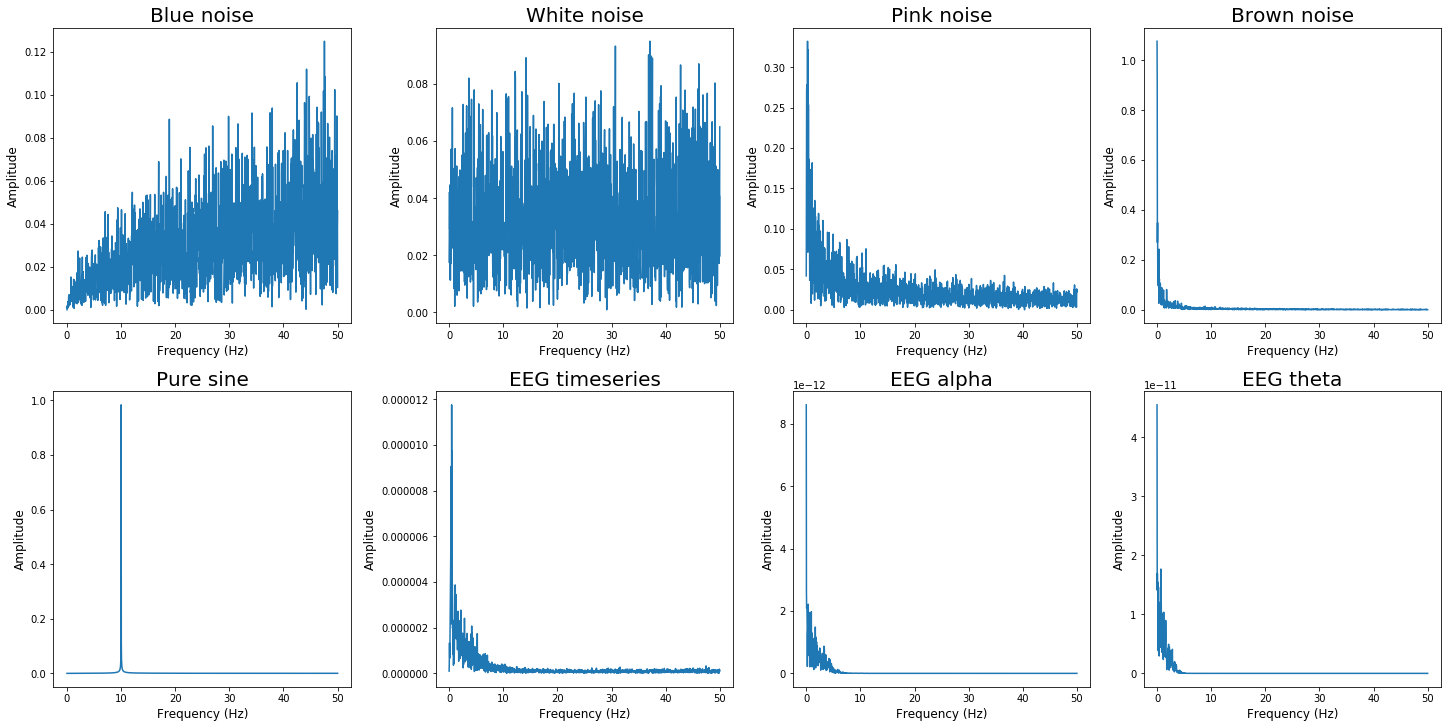

In [142]:
# The colors describe the spectral distribution of each kind of noise.
# So, in order to understand their differences, we should look a their spectrum !
# In white noise, all frequencies contribute equally.
# In pink noise, the relationship between the amplitude and the frequency follows a power law (1/f).
# Brown noise is similar to pink noise but follow a (1/f²) power law.


import scipy



def spectrum_plot(sig, ax, title = None):
    N = len(sig)
    # sample spacing
    T = 1.0 / sfreq
    yf = scipy.fftpack.fft(sig)
    xf = np.linspace(0.0, 1.0/(2.0*T), N/2) # The maths here are used to transform our fft
    ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))  # into an easily visualizable representation
    ax.set_xlabel('Frequency (Hz)', fontsize=12)
    ax.set_ylabel('Amplitude', fontsize=12)
    ax.set_title(title, fontsize=20)

    
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10), constrained_layout=True)
for i, ax in enumerate(axs.flat):
    spectrum_plot(sigs[i], ax, title=sig_names[i])


See ? The spectrum of the EEG timeseries seems to fall somewhere between pink and brown noise. 

### Awesome, but now...

... will you tell me what complexity means ? How do these flavours of noise differ in terms of Hurst exponent, Higuchi fractal dimension or SVD entropy ?

NeuroKit warning: complexity(): Failed to compute sample entropy (sampen).
NeuroKit warning: complexity(): Failed to compute sample entropy (sampen).
NeuroKit warning: complexity(): Failed to compute sample entropy (sampen).
NeuroKit warning: complexity(): Failed to compute sample entropy (sampen).
NeuroKit warning: complexity(): Failed to compute sample entropy (sampen).
NeuroKit warning: complexity(): Failed to compute sample entropy (sampen).
NeuroKit warning: complexity(): Failed to compute sample entropy (sampen).
NeuroKit warning: complexity(): Failed to compute sample entropy (sampen).
NeuroKit warning: complexity(): Failed to compute Multiscale Entropy (MSE).
NeuroKit warning: complexity(): Failed to compute Multiscale Entropy (MSE).
NeuroKit warning: complexity(): Failed to compute Multiscale Entropy (MSE).
NeuroKit warning: complexity(): Failed to compute Multiscale Entropy (MSE).
NeuroKit warning: complexity(): Failed to compute Multiscale Entropy (MSE).
NeuroKit warning: co

/home/hyruuk/anaconda3/envs/cbc/lib/python3.7/site-packages/neurokit/signal/complexity.py:526: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p, r1, r2, s)=np.linalg.lstsq(x, L)


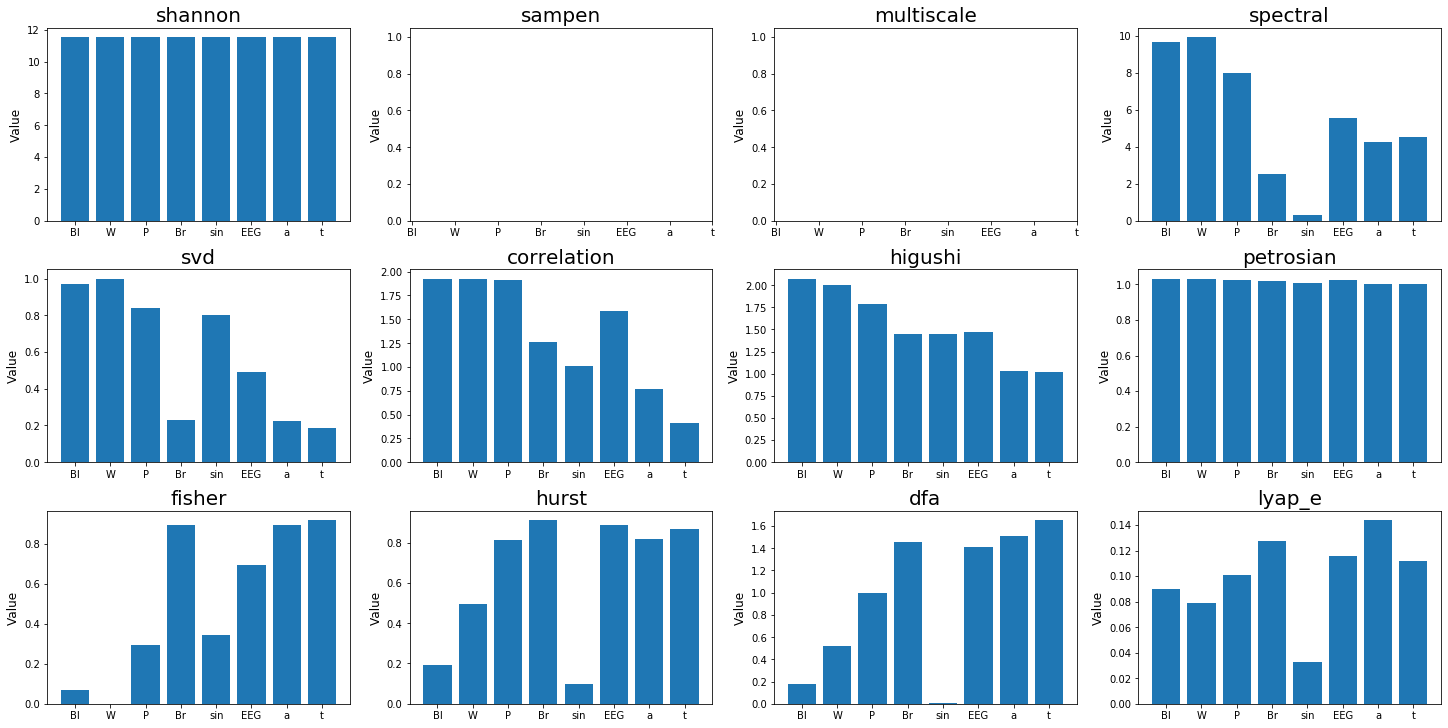

In [161]:
# Let's explore the complexity measures offered by NeuroKit !

def complexity_plot(sigs, sig_names, met, ax):
    comp_values = []
    for i, sig in enumerate(sigs):
        comp_values.append(comp_compute(sig, compute=met))
    ax.bar(np.arange(len(comp_values)), comp_values)
    ax.set_ylabel('Value', fontsize=12)
    ax.set_xticks(np.arange(len(sig_names)))
    ax.set_xticklabels(sig_names)
    ax.set_title(met, fontsize=20)
    return comp_values

    
fig, axs = plt.subplots(3,4,figsize=(20,10), constrained_layout=True)

metrics = ['shannon', 'sampen', 'multiscale', 'spectral', 'svd', 'correlation', 'higushi', 'petrosian', 'fisher', 'hurst', 'dfa', 'lyap_e']

sig_names_short = ['Bl', 'W', 'P', 'Br', 'sin', 'EEG', 'a', 't']
for i, ax in enumerate(axs.flat):
    comp_values = complexity_plot(sigs, sig_names_short, metrics[i], ax)
plt.savefig('comp_measures.png')

I remark that :
- Sample and multiscale entropy didn't compute
- Shannon entropy is largely the same for all signals, same for petrosian
- EEG signals are often comprised somewhere between Pink and Brown noise
- 0<H<0.5 means short term correlations (i.e., high frequencies), 0.5<H<1 means long term correlations (low frequencies)

## Now, are these metrics able to discriminate between mental states ?

- When applied on raw timeseries ?
- When applied on power band envelope ?
- What is the minimum time window required to keep this discriminant power ?
- How fast is it to compute ?

In [46]:
from mne.datasets import sleep_physionet
dl_path = sleep_physionet.age.fetch_data(subjects=[0], recording=[1]) # Downloads the sleep dataset
data_path = dl_path[0][0] # Get path of datafile
annot_path = dl_path[0][1] # Get path of annotations (sleep stages info) file


raw_data = mne.io.read_raw_edf(data_path) # Read datafile
sfreq = raw_data.info['sfreq'] # We'll need to keep this for later
annot = mne.read_annotations(annot_path) # Read sleep stages annotation file
raw_data.set_annotations(annot, emit_warning=False) # Link annotations to data

# With these files, MNE -wrongly- recognizes all channels as EEG.
# So we need to tell it which channel isn't EEG
mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}
raw_data.set_channel_types(mapping)
picks = mne.pick_types(raw_data.info, meg=False, eeg=True) # keep EEG indices in picks


# Segment data into epochs of different conditions (ex. wake vs sleep)
## first declare some variables
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

tmax = 30. - 1. / sfreq # define duration of an epoch, here we will take 30 seconds in order to reach 3000pts

## find events from annotations file
events, _ = mne.events_from_annotations(
    raw_data, event_id=annotation_desc_2_event_id, chunk_duration=tmax)

## segment datafile based on events
epochs = mne.Epochs(raw=raw_data, events=events, event_id=event_id,
                         tmin=0., tmax=tmax, baseline=None)

## split epochs in the two conditions
ep_wake = np.average(epochs['Sleep stage W'].get_data(picks=picks), axis=1) # Average across electrodes
ep_sleep = np.average(epochs['Sleep stage 3/4'].get_data(picks=picks), axis=1)



Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /home/hyruuk/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
100.0
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
2650 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 1997 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 220 events and 3000 original time points ...
0 bad epochs dropped


In [14]:
def comp_compute(data, verbose=False, compute='hurst'):
    shannon, sampen, multiscale, spectral, svd, correlation, higushi, petrosian, fisher, hurst, dfa, lyap_r, lyap_e = False, False, False, False, False, False, False, False, False, False, False, False, False

    if compute == 'shannon':
        shannon = True
    if compute == 'sampen':
        sampen = True
    if compute == 'multiscale':
        multiscale = True
    if compute == 'spectral': #### Maybe that huge wall can be improved
        spectral = True
    if compute == 'svd':
        svd = True
    if compute == 'correlation':
        correlation = True
    if compute == 'higushi':
        higushi = True
    if compute == 'petrosian':
        petrosian = True
    if compute == 'fisher':
        fisher = True
    if compute == 'hurst':
        hurst = True
    if compute == 'dfa':
        dfa = True
    if compute == 'lyap_r':
        lyap_r = True
    if compute == 'lyap_e':
        lyap_e = True

    start = time.time()
    comp = neurokit.complexity(data, sampling_rate=sfreq, 
                               shannon=shannon, 
                               sampen=sampen, 
                               multiscale=multiscale, 
                               spectral=spectral, 
                               svd=svd, 
                               correlation=correlation, 
                               higushi=higushi, 
                               petrosian=petrosian, 
                               fisher=fisher, 
                               hurst=hurst, 
                               dfa=dfa, 
                               lyap_r=lyap_r, 
                               lyap_e=lyap_e, 
                               emb_dim=2, tolerance="default", k_max=8, bands=None, tau=1)
    stop = time.time()
    
    if verbose==True:
        print("Computed in {} seconds".format(stop-start))
        print(comp)
        
    metric_name = [i for i in comp.keys()][0]
    return comp[metric_name]


def compute_A_vs_B(ep_cond1, ep_cond2, compute='hurst'):
    n_epochs = np.min([ep_cond1.shape[0], ep_cond2.shape[0]])  # The maximum number of epochs we can compare is constrained by the number of sleep epochs
    comp_cond1 = []
    comp_cond2 = []
    for epoch_id in range(n_epochs):
        comp_cond1.append(comp_compute(ep_cond1[epoch_id,:], compute=compute))
        comp_cond2.append(comp_compute(ep_cond2[epoch_id,:], compute=compute))
    comp_cond1 = np.array(comp_cond1)
    comp_cond2 = np.array(comp_cond2)
    tval, pval = ttest_ind(comp_cond1, comp_cond2)
    print('{} binomial pval with N={}, : {}'.format(compute, n_epochs, pval))
    return comp_cond1, comp_cond2, pval, n_epochs


def plot_A_vs_B(comp_cond1, comp_cond2, cond_names, pval, met, ax=None):
    ######### Create a boxplot
    
    #### Create dataframe for Seaborn
    values = np.hstack((comp_cond1, comp_cond2))
    condition = np.hstack(([cond_names[0]]*len(comp_cond1), [cond_names[1]]*len(comp_cond2)))
    d = {'Values': values, 'Condition': condition}
    df = pd.DataFrame(data=d)
    
    if ax == None:
        f, ax = plt.subplots(figsize=(7, 6))
    
    # Create boxes
    sns.boxplot(x="Condition", y="Values", data=df,
                whis="range", ax=ax)
    
    if len(comp_cond1) >= 50: # If n_epochs > 50 we use a violinplot  
        sns.violinplot(x="Condition", y="Values", data=df,
                      size=2, linewidth=0.5, ax=ax, palette='vlag')
    else: # Add in points to show each observation
        sns.swarmplot(x="Condition", y="Values", data=df,
              size=10, linewidth=0.5, ax=ax, palette='vlag')
    
    # Tweak the visual presentation
    ax.xaxis.grid(True);
    sns.despine(trim=True, left=True, ax=ax)
    
    # Add pvals in title
    if pval <= 0.05 and pval >= 0.01:
        ax.set_title(met + ' *')
    elif pval <= 0.01 and pval >= 0.001:
        ax.set_title(met + ' **')
    elif pval <= 0.001:
        ax.set_title(met + ' ***')
    else:
        ax.set_title(met)
        
    return ax

hurst binomial pval with N=220, : 3.334238143253699e-61
fisher binomial pval with N=220, : 3.125298698214363e-175


/home/hyruuk/anaconda3/envs/cbc/lib/python3.7/site-packages/neurokit/signal/complexity.py:526: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p, r1, r2, s)=np.linalg.lstsq(x, L)


higushi binomial pval with N=220, : 1.3482663055823895e-248


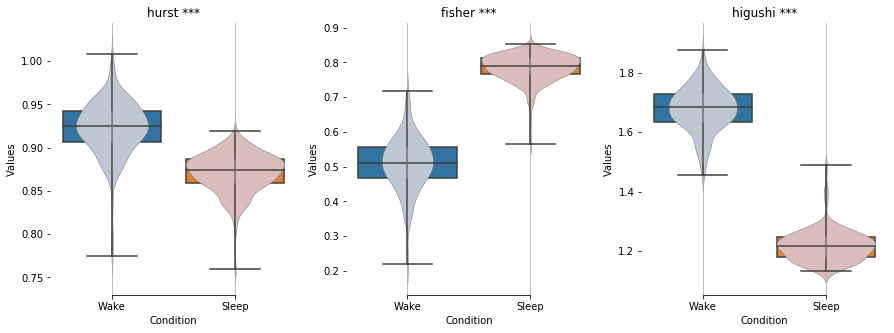

In [34]:



metrics = ['hurst', 'fisher', 'higushi']
fig, ax = plt.subplots(1, len(metrics), figsize=(5*(len(metrics)),5))
cond_names = ['Wake', 'Sleep']
for i, met in enumerate(metrics):
    # I'd love to keep only the first Y label but no idea how
    comp_wake, comp_sleep, pval,_ = compute_A_vs_B(ep_wake, ep_sleep, met)
    plot_A_vs_B(comp_wake, comp_sleep, cond_names, pval, met, ax=ax[i])

## Ok, so these metrics seem to be discriminant

But how do they behave when computed in pseudo-realtime ?


In [ ]:
comp_task

In [50]:
timeseries_rs.shape

(29, 3000)

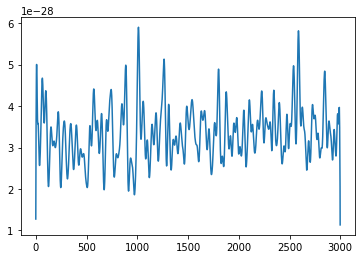

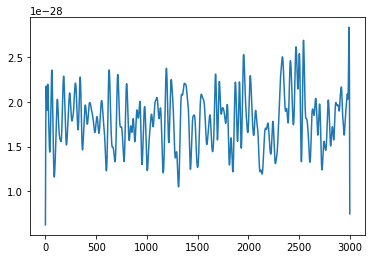

hurst binomial pval with N=29, : 3.2707376500754718e-06
svd binomial pval with N=29, : 0.025095974658014397
dfa binomial pval with N=29, : 0.0009841580862954057
higushi binomial pval with N=29, : 0.670989729029991


/home/hyruuk/anaconda3/envs/cbc/lib/python3.7/site-packages/neurokit/signal/complexity.py:526: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p, r1, r2, s)=np.linalg.lstsq(x, L)


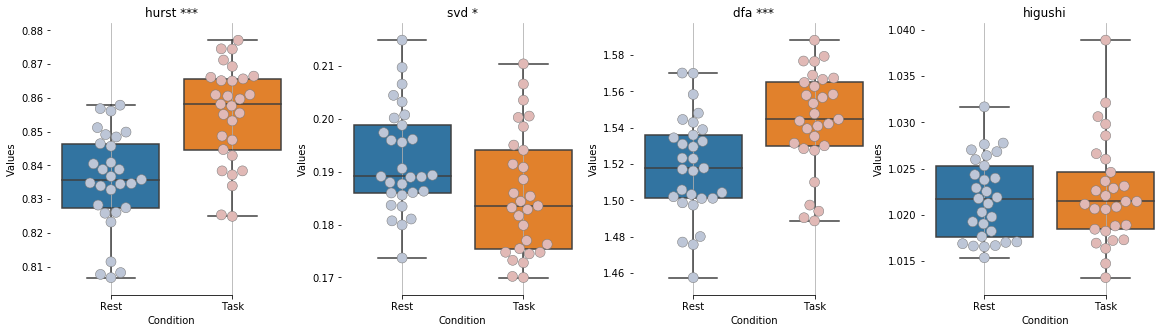

In [69]:
#### WITH MY OWN DATA =D

alpha_rs = get_hilbert(timeseries_rs, freq=0)
alpha_task = get_hilbert(timeseries_task, freq=0)


metrics = ['hurst', 'svd', 'dfa' ,'higushi']
cond_names = ['Rest', 'Task']
fig, ax = plt.subplots(1, len(metrics), figsize=(5*(len(metrics)),5))

for i, met in enumerate(metrics):
    # I'd love to keep only the first Y label but no idea how
    comp_rs, comp_task, pval,_ = compute_A_vs_B(alpha_rs, alpha_task, compute=met)
    plot_A_vs_B(comp_rs, comp_task, cond_names, pval, met, ax=ax[i])
    
plt.savefig('complexity_Task_v_Rest_theta_avgAllch.png', dpi=600)

In [ ]:

metrics = ['hurst', 'svd' ,'higushi']
cond_names = ['Rest', 'Task']
fig, ax = plt.subplots(1, len(metrics), figsize=(5*(len(metrics)),5))

for i, met in enumerate(metrics):
    # I'd love to keep only the first Y label but no idea how
    comp_rs, comp_task, pval,_ = compute_A_vs_B(timeseries_rs, timeseries_task, compute=met)
    plot_A_vs_B(comp_rs, comp_task, cond_names, pval, met, ax=ax[i])

In [ ]:
# Should I use EEG raw time series or power band envelopes ?

# What is the window size I want to use ?

# 

In [ ]:
###### DEPENDING ON WINDOW SIZE AND STEP

In [ ]:
### I want a plot that shows computation times for the different metrics, depending on n_sample

In [70]:
### I want a plot that shows timecourse of different metrics over time 

In [71]:
### I want a plot that shows timecourse of different metrics over time OVER the night, 
  # if possible applied over the hypnogram

In [ ]:
# What am I going to plot ???
# I want an interactive plot that shows the effect of adding +- of noise to the signal, 
# and check the changes on complexity measures.
# Barplot of the differents comp measures (Hurst, DFA, SVDE, SpectralE)


### I want to compare Higuchi, Hurst and DFA between sleep and wake
#- DONE

### I want to compare HHD 